In [1]:
"""Importing libraries"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from tqdm import tqdm
import time
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn import preprocessing, model_selection, pipeline
from sklearn.metrics import f1_score, roc_auc_score

from keras.models import Sequential
from keras.layers import LSTM, GRU, Embedding, BatchNormalization
from keras.layers.core import Dense, Activation, Dropout
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("../input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv")
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [3]:
"""Missing values"""
print(len(df.index))
df.isnull().sum()

17880


job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [4]:
print(len(df[df['fraudulent']==1].index))
df[df['fraudulent']==1].isnull().sum()

866


job_id                   0
title                    0
location                19
department             531
salary_range           643
company_profile        587
description              1
requirements           154
benefits               364
telecommuting            0
has_company_logo         0
has_questions            0
employment_type        241
required_experience    435
required_education     451
industry               275
function               337
fraudulent               0
dtype: int64

In [5]:
"""Extracting Text Featurs"""

text_df = df[["title", "company_profile", "description", "requirements", "benefits","fraudulent"]]
text_df = text_df.fillna(' ')

text_df.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


In [6]:
"""Catagorical Feature"""
cat_df = df[["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education", "industry", "function","fraudulent"]]
cat_df = cat_df.fillna("None")

cat_df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,0,Other,Internship,None,None,Marketing,0
1,0,1,0,Full-time,Not Applicable,None,Marketing and Advertising,Customer Service,0
2,0,1,0,None,None,None,None,None,0
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# Target

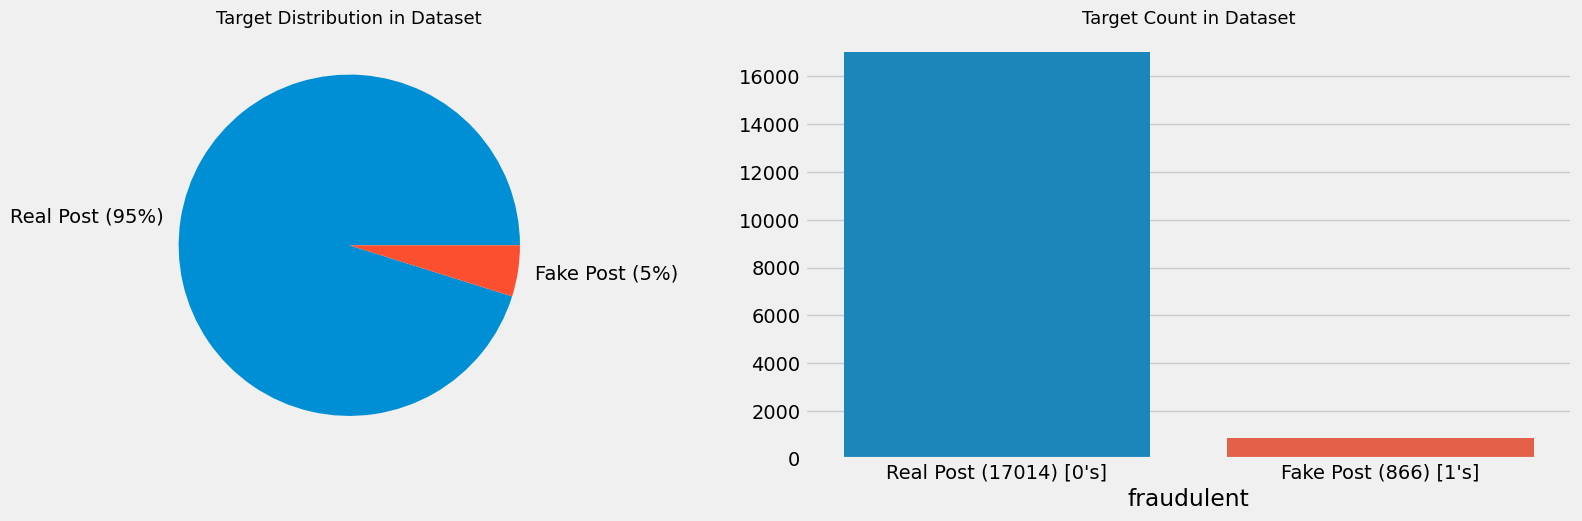

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
plt.tight_layout()

df["fraudulent"].value_counts().plot(kind='pie', ax=axes[0], labels=['Real Post (95%)', 'Fake Post (5%)'])
temp = df["fraudulent"].value_counts()
sns.barplot(x=temp.index,y= temp, ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')
axes[1].set_xticklabels(["Real Post (17014) [0's]", "Fake Post (866) [1's]"])

axes[0].set_title('Target Distribution in Dataset', fontsize=13)
axes[1].set_title('Target Count in Dataset', fontsize=13)

plt.show()

Hmm!! Class distributions are **95% for 0 (Real Post)** and **5% for 1 (Fake Post).** Target distribution is highly imbalanced. Accuracy metric is not useful here it will mislead the result. So, we've to look into Precision, Recall, F1 Score for model evalution.

# Exploratory Data Analysis of tweets

/tmp/ipykernel_32/1456831904.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels,  fontsize=10)
/tmp/ipykernel_32/1456831904.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels,  fontsize=10)
/tmp/ipykernel_32/1456831904.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels,  fontsize=10)
/tmp/ipykernel_32/1456831904.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels,  fontsize=10)
/tmp/ipykernel_32/1456831904.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels,  fontsize=10)
/tmp/ipykernel_32/1456831904.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels,  fontsize=10)


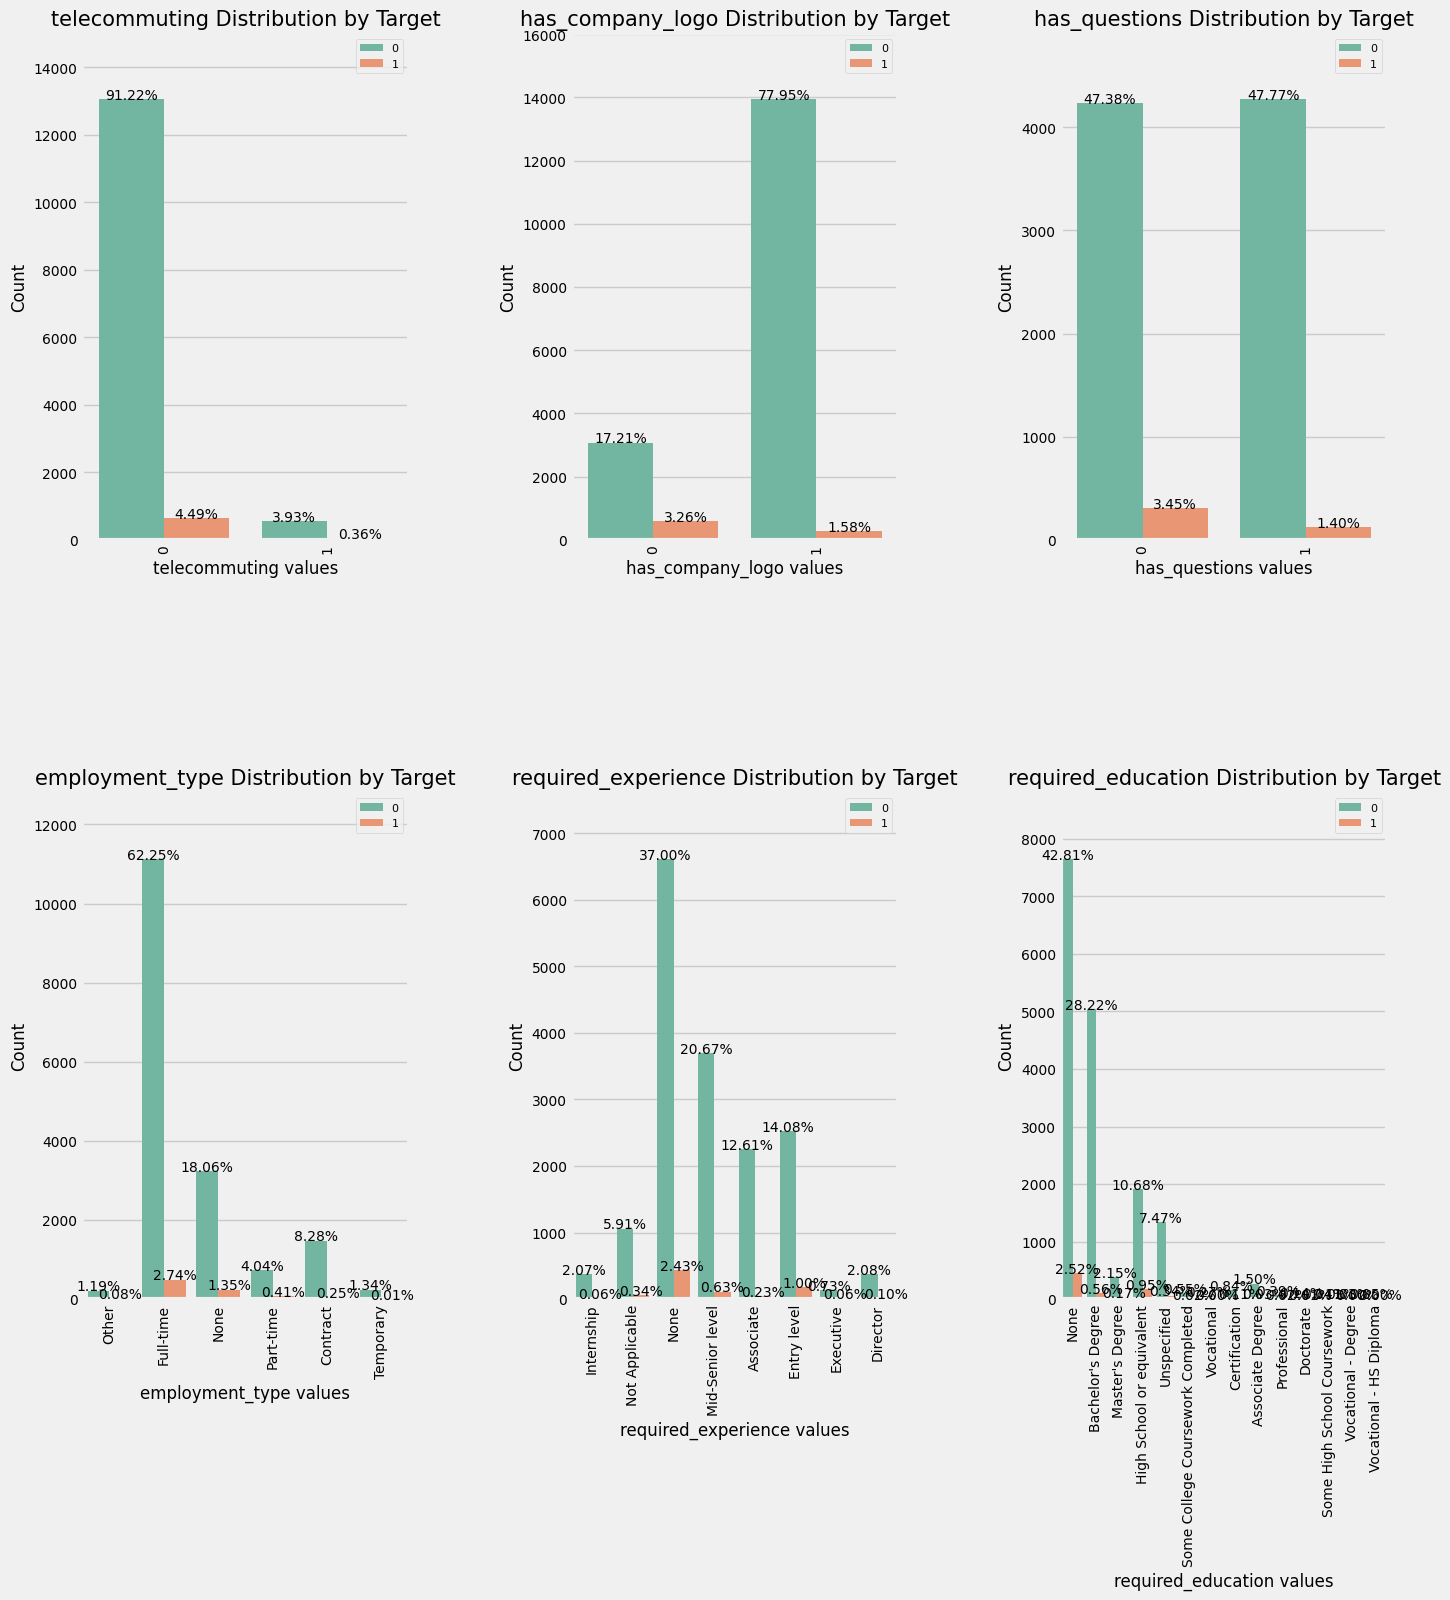

In [8]:
cat_cols = ["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education",]
# visualizating catagorical variable by target
import matplotlib.gridspec as gridspec # to do the grid of plots
grid = gridspec.GridSpec(3, 3, wspace=0.5, hspace=0.5) # The grid of chart
plt.figure(figsize=(15,25)) # size of figure

# loop to get column and the count of plots
for n, col in enumerate(cat_df[cat_cols]): 
    ax = plt.subplot(grid[n]) # feeding the figure of grid
    sns.countplot(x=col, data=cat_df, hue='fraudulent', palette='Set2') 
    ax.set_ylabel('Count', fontsize=12) # y axis label
    ax.set_title(f'{col} Distribution by Target', fontsize=15) # title label
    ax.set_xlabel(f'{col} values', fontsize=12) # x axis label
    xlabels = ax.get_xticklabels() 
    ylabels = ax.get_yticklabels() 
    ax.set_xticklabels(xlabels,  fontsize=10)
    ax.set_yticklabels(ylabels,  fontsize=10)
    plt.legend(fontsize=8)
    plt.xticks(rotation=90) 
    total = len(cat_df)
    sizes=[] # Get highest values in y
    for p in ax.patches: # loop to all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=10) 
    ax.set_ylim(0, max(sizes) * 1.15) #set y limit based on highest heights


plt.show()


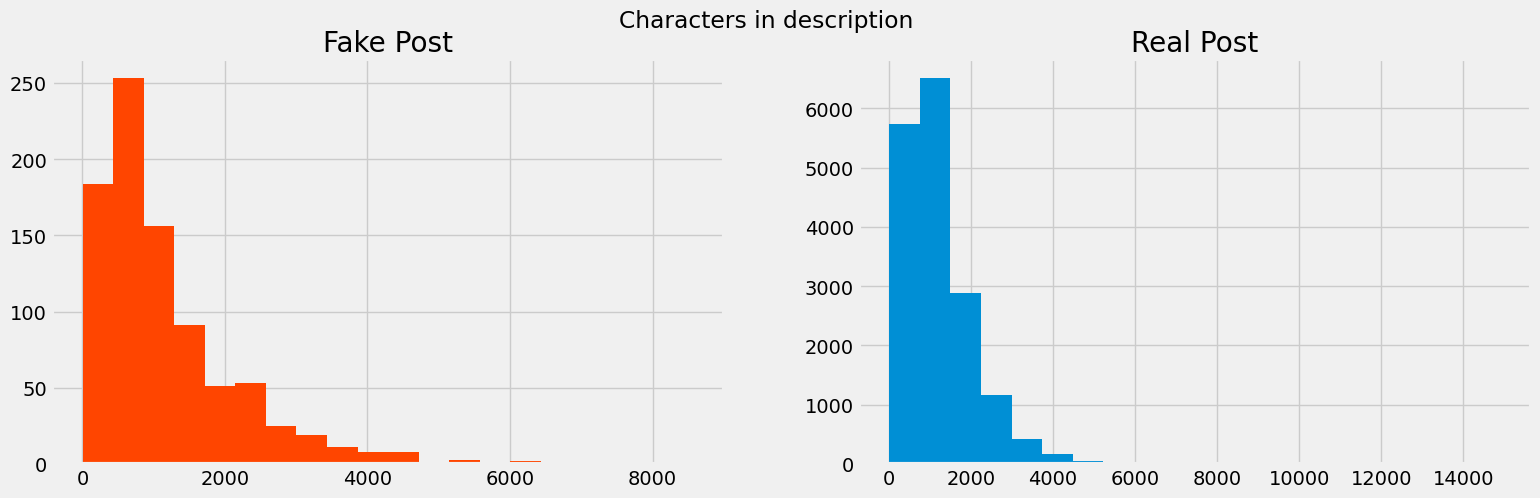

In [9]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length=text_df[text_df["fraudulent"]==1]['description'].str.len()
ax1.hist(length,bins = 20,color='orangered')
ax1.set_title('Fake Post')
length=text_df[text_df["fraudulent"]==0]['description'].str.len()
ax2.hist(length, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Characters in description')
plt.show()

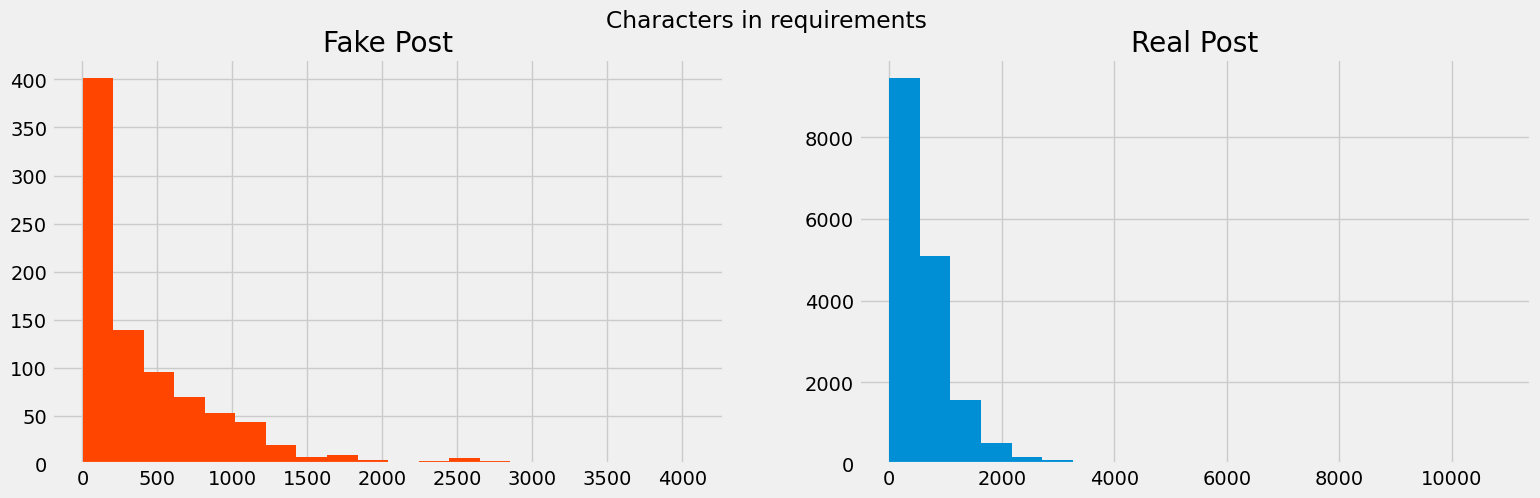

In [10]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length=text_df[text_df["fraudulent"]==1]['requirements'].str.len()
ax1.hist(length,bins = 20,color='orangered')
ax1.set_title('Fake Post')
length=text_df[text_df["fraudulent"]==0]['requirements'].str.len()
ax2.hist(length,bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Characters in requirements')
plt.show()

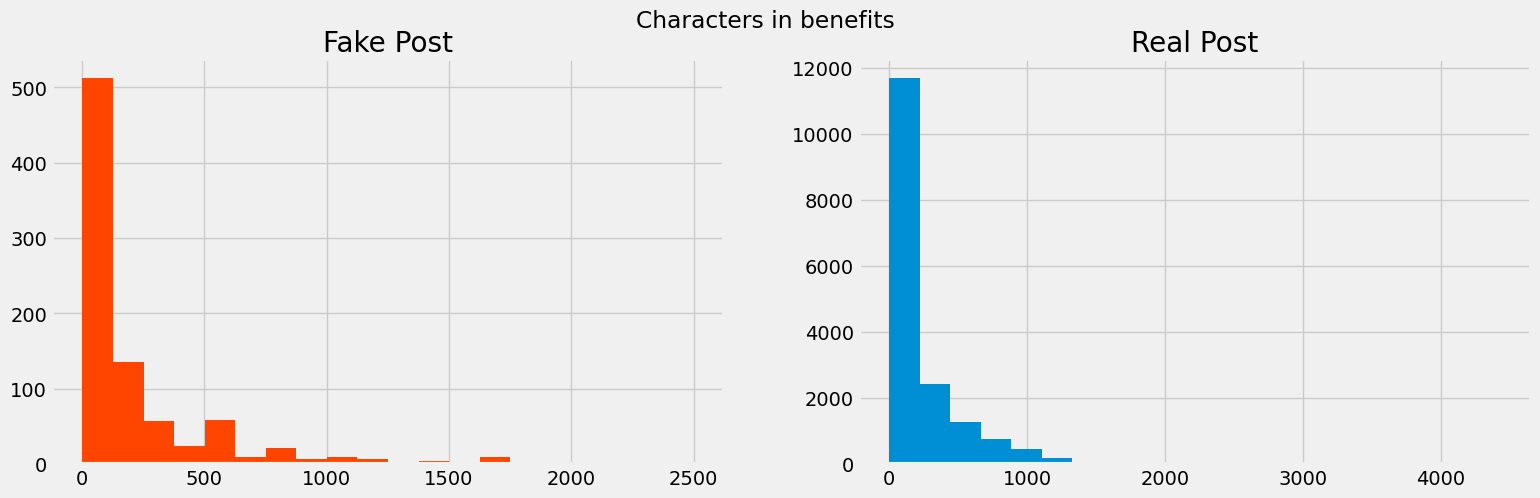

In [11]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length=text_df[text_df["fraudulent"]==1]['benefits'].str.len()
ax1.hist(length,bins = 20,color='orangered')
ax1.set_title('Fake Post')
length=text_df[text_df["fraudulent"]==0]['benefits'].str.len()
ax2.hist(length,bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Characters in benefits')
plt.show()

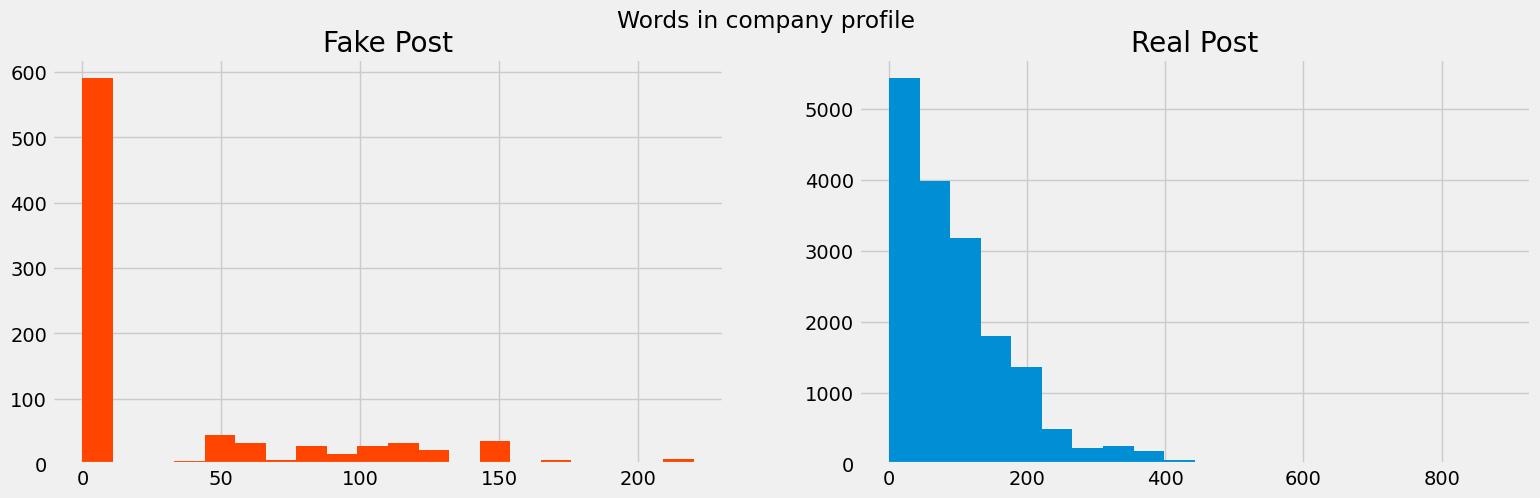

In [12]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=text_df[text_df["fraudulent"]==1]['company_profile'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='orangered')
ax1.set_title('Fake Post')
num=text_df[text_df["fraudulent"]==0]['company_profile'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Words in company profile')
plt.show()

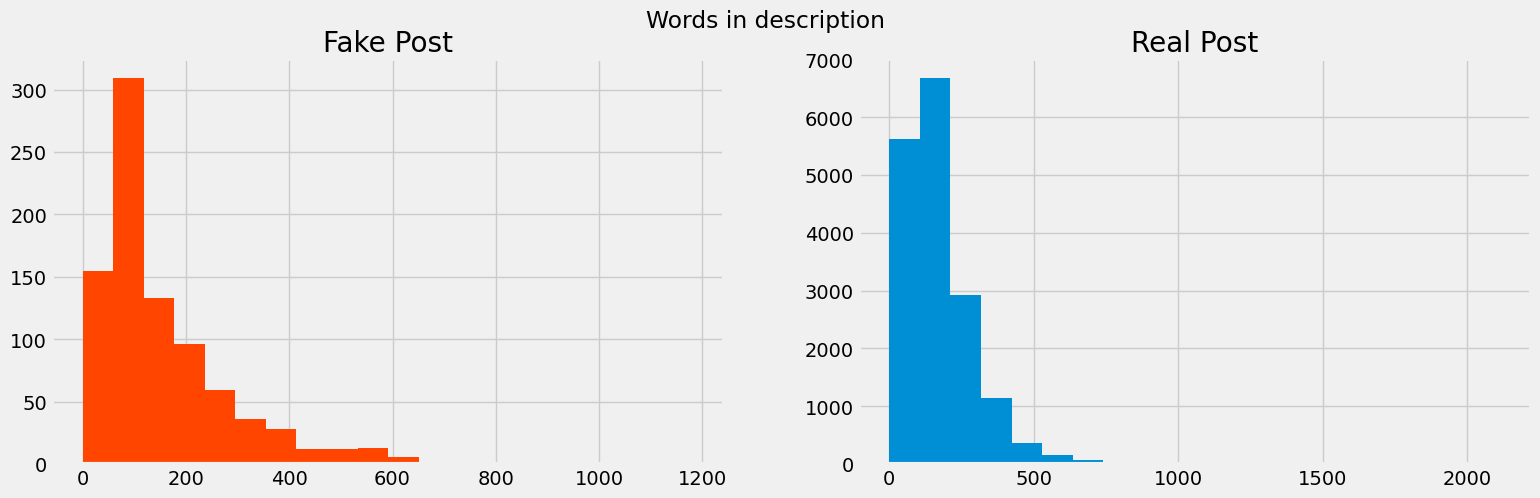

In [13]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=text_df[text_df["fraudulent"]==1]['description'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='orangered')
ax1.set_title('Fake Post')
num=text_df[text_df["fraudulent"]==0]['description'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Words in description')
plt.show()

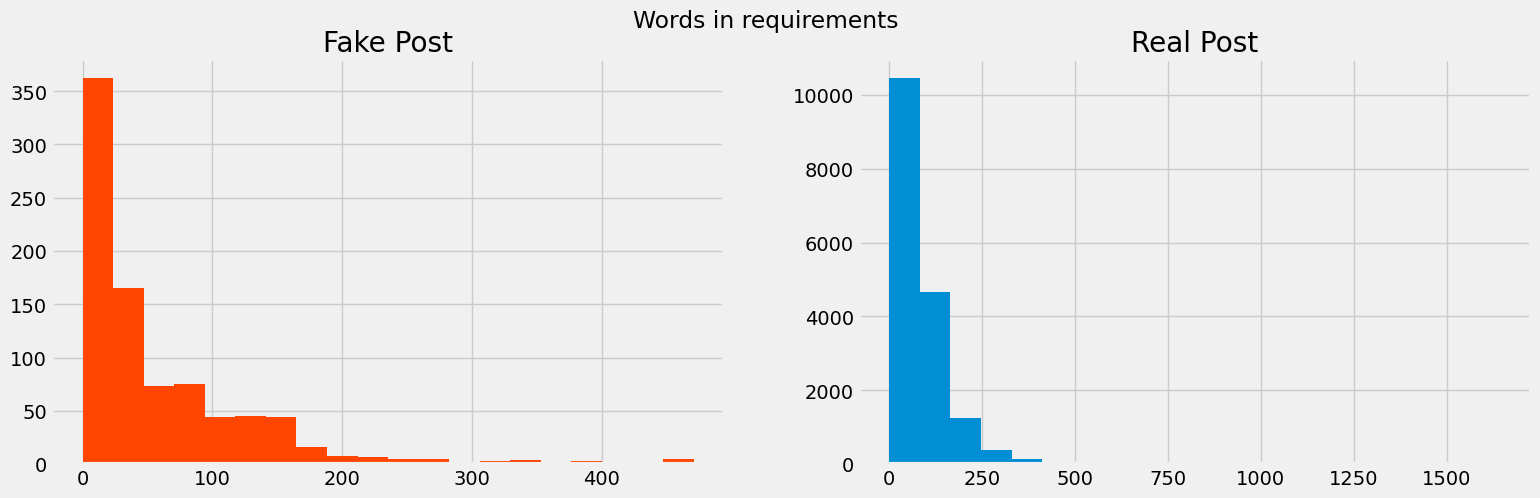

In [14]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=text_df[text_df["fraudulent"]==1]['requirements'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='orangered')
ax1.set_title('Fake Post')
num=text_df[text_df["fraudulent"]==0]['requirements'].str.split().map(lambda x: len(x))
ax2.hist(num,bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Words in requirements')
plt.show()

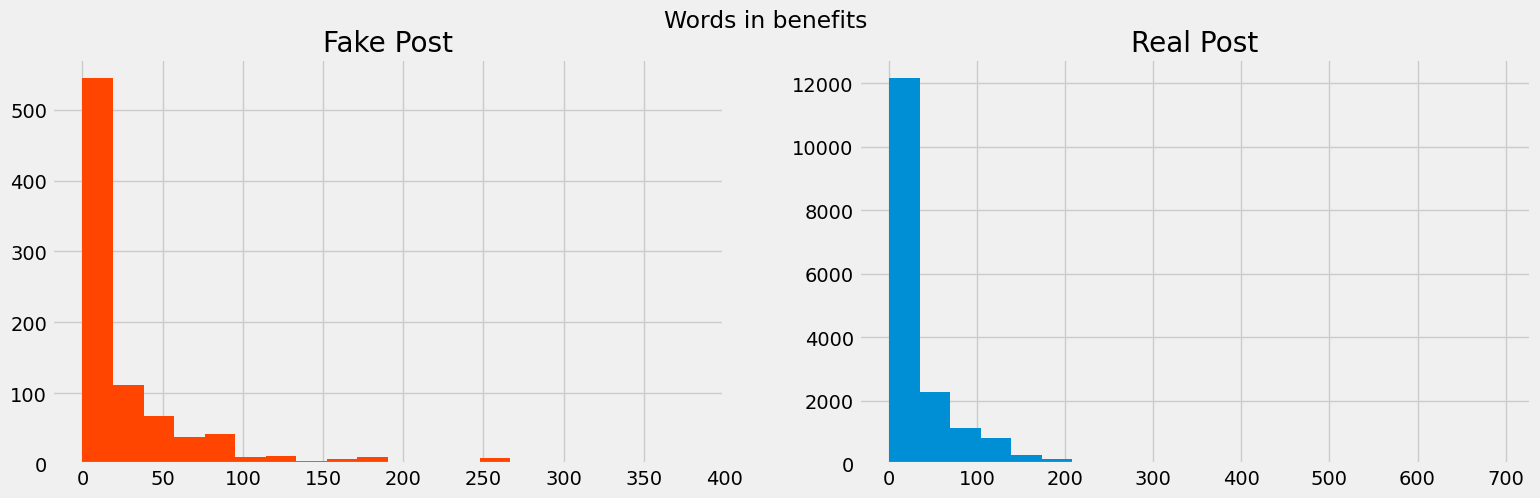

In [15]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=text_df[text_df["fraudulent"]==1]['benefits'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='orangered')
ax1.set_title('Fake Post')
num=text_df[text_df["fraudulent"]==0]['benefits'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Words in benefits')
plt.show()

In [16]:
"""Concate the text data for preprocessing and modeling"""
text = text_df[text_df.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
target = df['fraudulent']

print(len(text))
print(len(target))

17880
17880


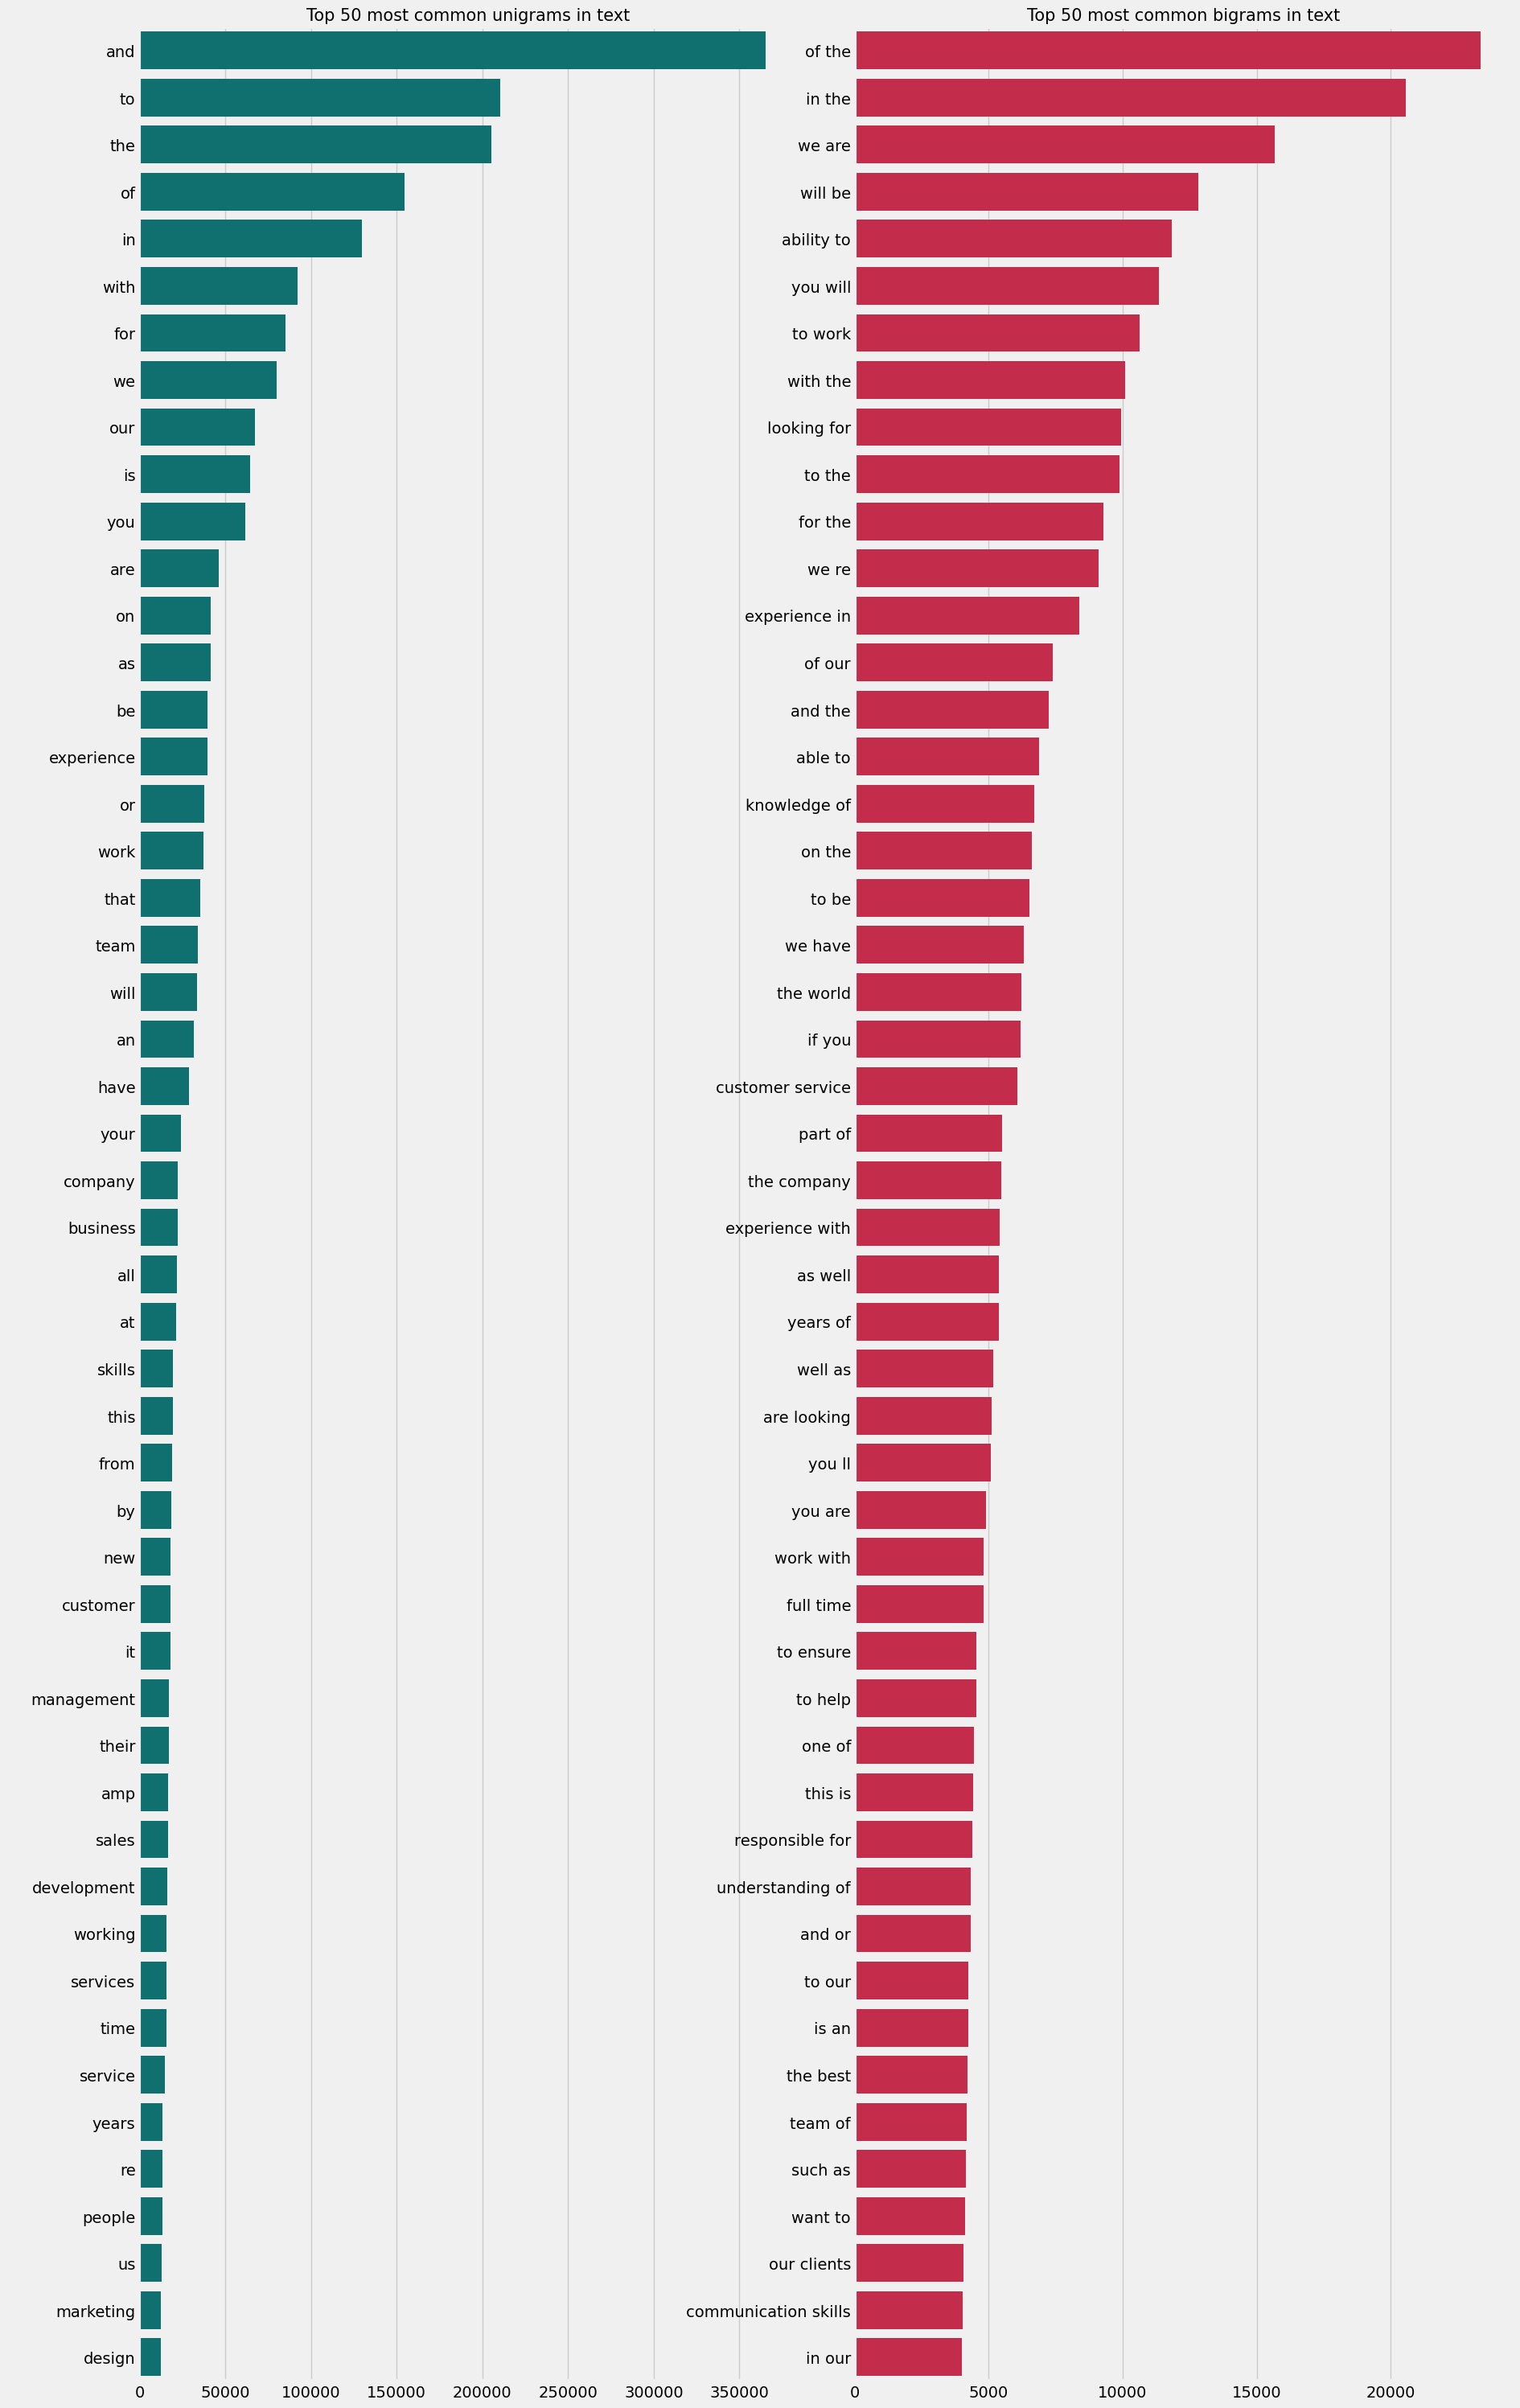

In [17]:
def get_top_tweet_unigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

fig, axes = plt.subplots(ncols=2, figsize=(18, 30), dpi=100)
plt.tight_layout()

top_unigrams=get_top_tweet_unigrams(text)[:50]
x,y=map(list,zip(*top_unigrams))
sns.barplot(x=y,y=x, ax=axes[0], color='teal')


top_bigrams=get_top_tweet_bigrams(text)[:50]
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x, ax=axes[1], color='crimson')


axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_title('Top 50 most common unigrams in text', fontsize=15)
axes[1].set_title('Top 50 most common bigrams in text', fontsize=15)

plt.show()

In [18]:
%%time
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


# Applying the cleaning function to both test and training datasets
text = text.apply(lambda x: clean_text(x))
text.head(3)

CPU times: user 15.5 s, sys: 26.4 ms, total: 15.5 s
Wall time: 15.5 s


0    marketing internwere  and weve created a groun...
1    customer service  cloud video  seconds the wor...
2    commissioning machinery assistant cmavalor ser...
dtype: object

# Bert 

In [19]:
new_text = text_df['description']
# text_df[text_df.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
target = df['fraudulent']

In [20]:
%%time
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


# Applying the cleaning function to both test and training datasets
new_text = new_text.apply(lambda x: clean_text(x))
new_text.head(3)

CPU times: user 6.95 s, sys: 1.83 ms, total: 6.95 s
Wall time: 6.95 s


0     a fastgrowing james beard awardwinning online...
1    organised  focused  vibrant  awesomedo you hav...
2    our client located in houston is actively seek...
Name: description, dtype: object

In [21]:
from sklearn.model_selection import train_test_split
trainX, valX, trainY, valY = train_test_split(new_text,target,test_size=0.2,stratify=target, random_state=420)

In [22]:
import datasets
Train = pd.DataFrame({"text":trainX,"label":trainY})
Val = pd.DataFrame({"text":valX, "label":valY})
Train = datasets.Dataset.from_pandas(Train)
Val = datasets.Dataset.from_pandas(Val)

In [23]:
!pip install evaluate
import evaluate

ROC = evaluate.load("roc_auc")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.2 MB/s eta 0:00:00


In [24]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    score = ROC.compute(prediction_scores=predictions, references=labels)
    return score

In [25]:
Train = Train.map(preprocess_function)
Val = Val.map(preprocess_function)

  0%|          | 0/14304 [00:00<?, ?ex/s]

  0%|          | 0/3576 [00:00<?, ?ex/s]

In [26]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [27]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
from transformers import create_optimizer
import tensorflow as tf

batch_size = 16
num_epochs = 3
batches_per_epoch = len(Train) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [29]:
tf_train_set = model.prepare_tf_dataset(
    Train,
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    Val,
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [30]:
from transformers.keras_callbacks import KerasMetricCallback

model.compile(optimizer=optimizer)

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

callbacks = [metric_callback]

In [31]:
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=3, callbacks=callbacks)

Epoch 1/3
894/894 [==============================] - 1071s 1s/step - loss: 0.1345 - val_loss: 0.0856 - roc_auc: 0.7364
Epoch 2/3
894/894 [==============================] - 992s 1s/step - loss: 0.0642 - val_loss: 0.0638 - roc_auc: 0.8413
Epoch 3/3
894/894 [==============================] - 984s 1s/step - loss: 0.0275 - val_loss: 0.0689 - roc_auc: 0.8534


In [32]:
predict = model.predict(x=tf_validation_set)

224/224 [==============================] - 74s 316ms/step


In [45]:
from sklearn.metrics import precision_recall_fscore_support
predicted = np.argmax(predict[0],axis=1)
precision_recall_fscore_support(Val['label'], predicted, average='binary', pos_label=1)

(0.8978102189781022, 0.7109826589595376, 0.7935483870967742, None)

In [34]:
predicted

array([0, 0, 0, ..., 0, 0, 0])

In [35]:
# predict[0]
compute_metrics([predict[0],Val['label']])


{'roc_auc': 0.8534343209578764}

In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix(predicted, Val['label'])


array([[3389,   50],
       [  14,  123]])

In [46]:
FP, FN = 0, 0
for i,j in zip(Val['label'], predicted):
    if i != j:
        if i==0 and j==1:
            FP+=1
        if i==1 and j==0:
            FN+=1
print(FP, FN)

14 50


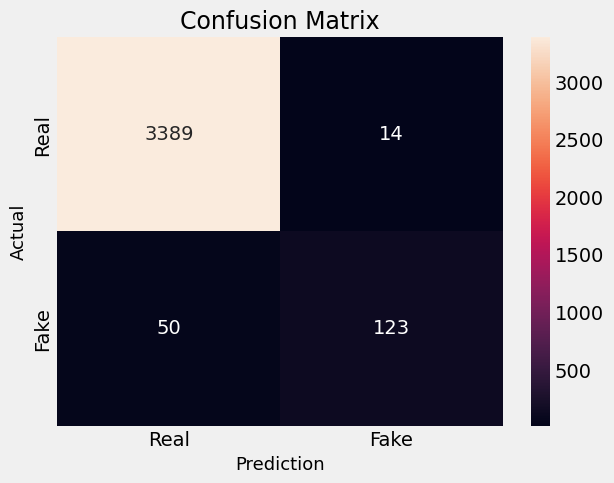

In [53]:
cm = confusion_matrix(Val['label'], predicted)
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['Real','Fake'],
            yticklabels=['Real','Fake'])
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()